In [1]:
import json
import cs_vqe.circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
import utils.linalg_tools as la
from utils.molecule_tools import get_molecule
from utils.cs_vqe_tools import greedy_dfs
from matplotlib import pyplot as plt
import numpy as np
from qiskit.aqua.components.optimizers import IMFIL, NELDER_MEAD, POWELL, NFT, SPSA, SLSQP, SNOBFIT, COBYLA

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)
    
model_data.keys()

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'H3+_STO-3G_SINGLET_alt', 'HeH+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET_alt', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET_alt', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'N+_STO-3G_SINGLET', 'OH+_STO-3G_SINGLET', 'CH2_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_SINGLET', 'NH_STO-3G_SINGLET', 'F+_STO-3G_SINGLET', 'Li+_STO-3G_SINGLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET'])

In [3]:
speciesname = "Be_STO-3G_SINGLET"
molecule    = model_data[speciesname]

ham         = molecule['ham']
uccsd       = molecule['uccsd']
hf_config   = molecule['hf_config']
num_qubits  = molecule['num_qubits']
terms_noncon= molecule['terms_noncon']
num_tapered = molecule['num_tapered']
print(num_tapered+num_qubits, num_qubits)

10 5


Be_STO-3G_SINGLET reaches chemical accuracy for 3-qubit CS-VQE


/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


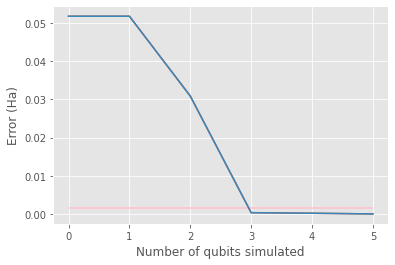

In [4]:
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian = ham,
                                  terms_noncon= terms_noncon,
                                  num_qubits  = num_qubits,
                                  hf_config   = hf_config)

num_sim_q = mol_circ.chem_acc_num_q
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
mol_circ.plot_cs_vqe_errors()

In [5]:
la.get_ground_state(qonvert.dict_to_WeightedPauliOperator(mol_circ.ham_reduced[num_sim_q]).to_matrix())[1]

array([-1.29734516e-01+1.34557418e-01j,  1.38777878e-17+0.00000000e+00j,
        1.29734516e-01-1.34557418e-01j,  1.11022302e-16-5.55111512e-17j,
        0.00000000e+00+2.77555756e-16j,  4.20450881e-01-8.47591191e-01j,
       -1.67444192e-01-8.30613380e-02j, -1.11022302e-16+0.00000000e+00j])

In [6]:
#anz_ops = mol_circ.sufficient_anz_terms(uccsd)

In [7]:
#import random
ham_red = mol_circ.ham_reduced[num_sim_q]
#anz_indices = [random.randint(0, len(uccsd.keys())) for i in range(1)]
#print(anz_indices)
#anz_ops = ['XIZXX', 'IYZXX'] #for B+ 
anz_ops = ['ZYZXX', 'IIYXX', 'XIIYX', 'IYZXX'] #for Be
#anz_ops = ['ZYXII', 'XIIXX', 'ZXYII'] #for C
#for LiH anz_ops = ['YXIIIIXX', 'IIIIYZXI', 'XZIIZYIX', 'IYIIYIIX', 'IIIIYYYX'] #doesn't quite hit qa
#LiH anz_ops = ['YXIIIIXX'] #['YXIIIIXX', 'IIIIYZXI', 'XZIIZYIX', 'IYIIYIIX', 'IIIIYYYX', 'IYIIXIIY', 'IIIIIXZY', 'XZIIZZYI', 'IIIIXYXX', 'IIIIYYXY', 'IXIIXIIY', 'IIIIXYYY', 'ZYZZYIZY', 'IIIIIYZX', 'IXIIXIIX', 'YZIIYIYZ', 'YZZZYIYZ', 'IYIIXIIX', 'YIIIIIXZ', 'YIIIXZYI', 'YZIIXIYZ', 'YZZIYIYZ', 'YZIZYIYZ', 'ZXIIIIIY', 'ZXIIXZZX', 'IXIIYIIY', 'IXIIYIIX', 'IYIIYIIY', 'IYIIZZZX', 'YIIIYZXI', 'YZIIZXIY', 'YZIIXIXZ', 'YZZZXIXZ']
#anz_ops = ['YXIIXXII', 'IXIIZZZY', 'XYIIZZXX', 'YYIIXYII'] #for HF
#for OH+ anz_ops = 
#anz_indices = [49, 97, 71, 72] #for C

#anz=uccsd
anz = {op:uccsd[op] for op in anz_ops}
anz_red = mol_circ.project_anz_terms_alt(anz_terms=anz, num_sim_q = num_sim_q)
ham_red = mol_circ.ham_reduced[num_sim_q]
qc = mol_circ.build_circuit(anz, num_sim_q)
init_params = mol_circ.init_param

print('Number of circuit parameters:', qc.num_parameters, '\n')


Number of circuit parameters: 7 



/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


# Performing the simulation *without* noise

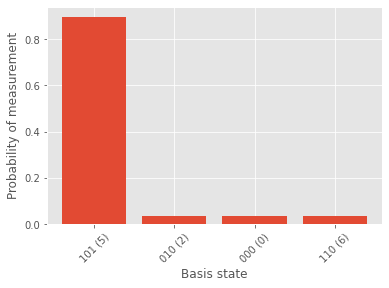

*   Performing 3-qubit CS-VQE over qubit positions 3, 2, 0 ...


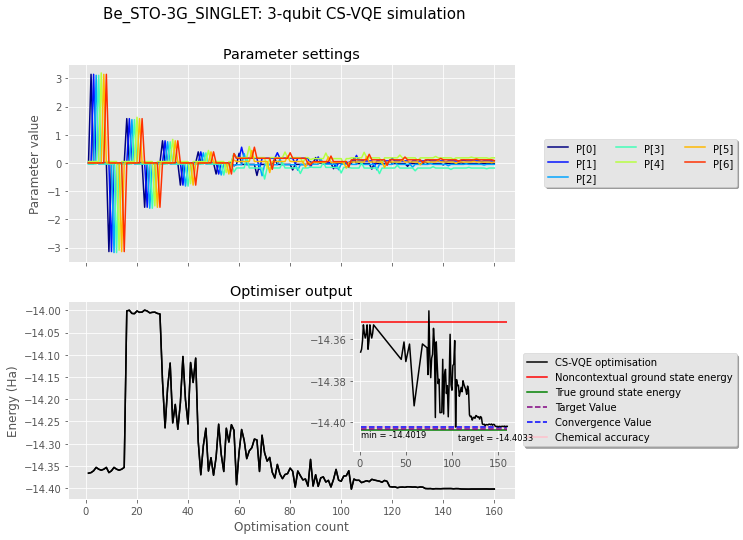

In [9]:
cs_vqe_results = mol_circ.CS_VQE(anz_terms=anz, 
                                 num_sim_q=num_sim_q, 
                                 optimizer=IMFIL(maxiter=1000), 
                                 param_bound=np.pi,
                                 noise=False,
                                show_amps=True)

title = '%s: %i-qubit CS-VQE simulation' % (speciesname, num_sim_q)
fig = plot.plot_parameter_settings(cs_vqe_results, title=title)

In [30]:
import json 

data={}
for k in cs_vqe_results.keys():
    data[str(k)] = cs_vqe_results[k]
    
with open("data/IBMQ-runtime/"+speciesname+"/statevectorsim.json", "w") as outfile: 
    json.dump(data, outfile)

In [8]:
#param_hist = [config for param, config in cs_vqe_results['params'].items()]
#init_params = np.array(list(zip(*param_hist))[-1])

# Performing the simulation *with* noise

The noise model used below emulates IBM's 5-qubit Vigo device, derived from real-life performance data

In [29]:
from qiskit import IBMQ
from utils.circuit_execution_tools import remote_circuit_execution
from matplotlib import pyplot as plt
plt.style.use('ggplot')
with open('data/token.txt', 'r') as file:
    TOKEN = file.read()
IBMQ.save_account(TOKEN, overwrite=True)
IBMQ.load_account()

/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
ibmqfactory.load_account:WARNING:1970-01-01 07:06:51,215: Credentials are already in use. The existing account in the session will be replaced.
/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [30]:
#data, raw_data = remote_circuit_execution(mol_circ=mol_circ, num_sim_q=num_sim_q, anz_op=anz, maxiter=150, qfi_resamples=150, zero_params=True)

In [31]:
#fig = plot.plot_parameter_settings_alt(data, log_error=True)

In [32]:
provider = IBMQ.get_provider(hub='ibm-q',group='open',project='main')
backends = [b.name() for b in provider.backends() if b.configuration().num_qubits==5]
backends

['ibmq_santiago',
 'ibmq_bogota',
 'ibmq_lima',
 'ibmq_belem',
 'ibmq_quito',
 'ibmq_manila']

In [39]:
remote_circuit_execution(mol_circ=mol_circ, num_sim_q=num_sim_q, anz_op=anz, maxiter=150, qfi_resamples=150, zero_params=True)#, backend="ibmq_manila")

KeyboardInterrupt: 

In [20]:
cs_vqe_results['result']

-98.60176689692878

runtime_job._start_websocket_client:WARNING:1970-01-01 05:12:07,776: An error occurred while streaming results from the server for job c5ta97ikh8krlc7f8700:
Traceback (most recent call last):
  File "/home/ucaptwe/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/runtime/runtime_job.py", line 325, in _start_websocket_client
    self._ws_client.job_results()
  File "/home/ucaptwe/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/api/clients/runtime_ws.py", line 74, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/home/ucaptwe/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/api/clients/base.py", line 211, in stream
    raise WebsocketError(error_message)
qiskit.providers.ibmq.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "/home/ucaptwe/anaconda3/lib/python3.8/site-packages/websocket/_app.py", line 369, in